In [1]:

from pathlib import Path

import torch

from torch_geometric.data import Data

from rdkit import Chem

root: Path = Path("/Users/arvandkaveh/Projects/kit/graph_hdc")
smiles_dir: Path = root / "Smiles/ZINC_smile"
files: list[Path] = [
    smiles_dir / "train_smile.txt",
    smiles_dir / "test_smile.txt",
    smiles_dir / "valid_smile.txt",
    smiles_dir / "debug_smile.txt",
]
N: int = 100  # target count


def iter_smiles(file: Path):
    """Yield SMILES strings from each file, skipping an optional header."""
    with open(file) as fh:
        for line_no, line in enumerate(fh):
            if line_no == 0 and line.strip().lower() == "smiles":
                continue
            s = line.strip().split()[0]
            if s:
                yield s

In [22]:

from rdkit.Chem import Atom


def atom_key(atom: Atom) -> dict[str, object]:
    """Full categorical signature (not used downstream, but handy for debugging)."""
    return {
        "symbol": atom.GetSymbol(),
        "degree": atom.GetDegree(),
        "charge": atom.GetFormalCharge(),
        "num_h": atom.GetTotalNumHs(),
        # "valence": atom.GetValence(ValenceType.EXPLICIT),
        # "aromatic": atom.GetIsAromatic(),
        # "in_ring": atom.IsInRing(),
    }


def build_lookup(mols: set[Chem.rdchem.Mol]):
    symbols = sorted({a.GetSymbol() for m in mols for a in m.GetAtoms()})
    atom2idx = {s: i for i, s in enumerate(symbols)}
    idx2atom = {i: s for s, i in atom2idx.items()}
    return atom2idx, idx2atom

def mol_to_data(mol: Chem.rdchem.Mol, atom2idx: dict):
    x = [
        [
            float(atom2idx[a.GetSymbol()]),
            float(a.GetDegree()),
            float(a.GetFormalCharge()),
            float(a.GetTotalNumHs(includeNeighbors=True)),
        ]
        for a in mol.GetAtoms()
    ]
    ei_src, ei_dst = [], []
    for b in mol.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        ei_src += [i, j]
        ei_dst += [j, i]
    return Data(
        x=torch.tensor(x, dtype=torch.float32),
        edge_index=torch.tensor([ei_src, ei_dst], dtype=torch.long),
        smiles=Chem.MolToSmiles(mol),
    )

In [23]:
## Debugging
debug_smiles = list(iter_smiles(files[3]))
debug_mols = [Chem.MolFromSmiles(s) for s in debug_smiles]
atom2idx_debug, idx2atom_debug = build_lookup(set(debug_mols))
debug_set = [mol_to_data(m, atom2idx_debug) for m in debug_mols]

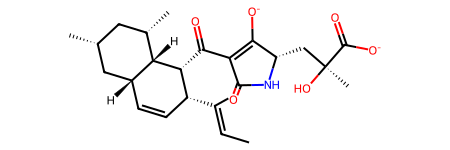

In [24]:
from rdkit.Chem import Mol, ValenceType
from IPython.display import display

mol: Mol = debug_mols[0]
display(mol)


In [25]:
from rdkit.Chem import Atom

print("Original:")
atoms = [a.GetSymbol() for a in mol.GetAtoms()]
print(atoms)
print(Chem.MolToSmiles(mol))
print("Sum Degrees:")
print(sum(map(lambda x: x.GetDegree(), mol.GetAtoms())))
print("Num Bonds")
print(mol.GetNumBonds())
print(len(mol.GetAtoms()))
print(mol_to_data(mol, atom2idx_debug))

one_atom: Atom = list(mol.GetAtoms())[0]
print(dir(one_atom))
print(type(one_atom))
carbon = Atom("C")
print(type(carbon))
print(carbon.GetAtomicNum())

print("\nNitrogens:")
nitrogens = [(a.GetIsAromatic(), a.GetFormalCharge(), a.GetTotalNumHs(), a.GetDegree()) for a in mol.GetAtoms() if a.GetSymbol() == 'N']
print(nitrogens)


print("\nAromatics")
print(list(map(lambda x: x.GetSymbol(), list(mol.GetAromaticAtoms()))))
aromatics = [(a.GetSymbol(), a.GetFormalCharge(), a.GetTotalNumHs(), a.GetDegree()) for a in mol.GetAtoms() if a.GetIsAromatic()]
print(aromatics)
data = mol_to_data(mol, atom2idx_debug)
print(data.x)
print(data.edge_index)

Original:
['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'O', 'N', 'C', 'O']
C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O
Sum Degrees:
68
Num Bonds
34
32
Data(x=[32, 4], edge_index=[2, 68], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
['ClearProp', 'ClearPropertyCache', 'DescribeQuery', 'GetAtomMapNum', 'GetAtomicNum', 'GetBonds', 'GetBoolProp', 'GetChiralTag', 'GetDegree', 'GetDoubleProp', 'GetExplicitBitVectProp', 'GetExplicitValence', 'GetFormalCharge', 'GetHybridization', 'GetIdx', 'GetImplicitValence', 'GetIntProp', 'GetIsAromatic', 'GetIsotope', 'GetMass', 'GetMonomerInfo', 'GetNeighbors', 'GetNoImplicit', 'GetNumExplicitHs', 'GetNumImplicitHs', 'GetNumRadicalElectrons', 'GetOwningMol', 'GetPDBResidueInfo', 'GetProp', 'GetPropNames', 'GetPropsAsDict', 'GetQu

## Manipulations, Positive and Negative

#### Positive

In [34]:
from typing import Optional
import random


def subgraphs_remove_one_leaf(mol: Mol, n: Optional[int] = None) -> set[Mol]:
    out, seen = set(), set()
    leaves = [a.GetIdx() for a in mol.GetAtoms() if a.GetDegree() == 1]
    for idx in leaves:
        # Read Write Mol is designed to be fast and editable
        rw = Chem.RWMol(mol)
        rw.RemoveAtom(idx)
        try:
            sub = rw.GetMol()
            # run RDKit’s consistency checks: valence, aromaticity perception, kekulisation, etc.
            # If the edit produced an illegal structure (e.g. broke aromaticity in a way the toolkit can’t rescue), this call raises.
            # TODO: Depending on the generator we might wanna also allow illegal one. If generator can only create legal subgraphs then this is okey
            Chem.SanitizeMol(sub)
            sub.UpdatePropertyCache()
        except Chem.rdchem.KekulizeException:
            continue
        smi = Chem.MolToSmiles(sub, canonical=True)
        if smi in seen:
            continue
        out.add(sub)
        seen.add(smi)
        if n and len(out) == n:
            break
    return out

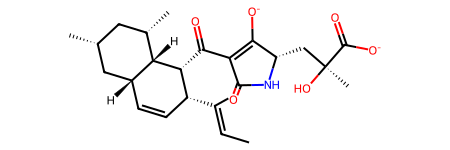

Data(x=[32, 4], edge_index=[2, 68], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
[('C', 1, 0, 3), ('C', 2, 0, 1), ('C', 3, 0, 0), ('C', 1, 0, 3), ('C', 3, 0, 1), ('C', 2, 0, 1), ('C', 2, 0, 1), ('C', 3, 0, 1), ('C', 2, 0, 2), ('C', 3, 0, 1), ('C', 1, 0, 3), ('C', 2, 0, 2), ('C', 3, 0, 1), ('C', 1, 0, 3), ('C', 3, 0, 1), ('C', 3, 0, 1), ('C', 3, 0, 0), ('O', 1, 0, 0), ('C', 3, 0, 0), ('C', 3, 0, 0), ('O', 1, -1, 0), ('C', 3, 0, 1), ('C', 2, 0, 2), ('C', 4, 0, 0), ('C', 1, 0, 3), ('O', 1, 0, 1), ('C', 3, 0, 0), ('O', 1, 0, 0), ('O', 1, -1, 0), ('N', 2, 0, 1), ('C', 3, 0, 0), ('O', 1, 0, 0)]
32
Counter({('C', 3, 0, 1): 7, ('C', 3, 0, 0): 6, ('C', 1, 0, 3): 5, ('C', 2, 0, 1): 3, ('C', 2, 0, 2): 3, ('O', 1, 0, 0): 3, ('O', 1, -1, 0): 2, ('C', 4, 0, 0): 1, ('O', 1, 0, 1): 1, ('N', 2, 0, 1): 1})
32


In [35]:
from collections import Counter

display(mol)
print(mol_to_data(mol, atom2idx_debug))
atoms = list(map(lambda atom: tuple(atom_key(atom).values()), mol.GetAtoms()))
print(atoms)
print(len(atoms))
atom_counter = Counter(atoms)
print(atom_counter)
print(atom_counter.total())

{<rdkit.Chem.rdchem.Mol at 0x17f786420>,
 <rdkit.Chem.rdchem.Mol at 0x17f7870d0>}

-----ORIGINAL----


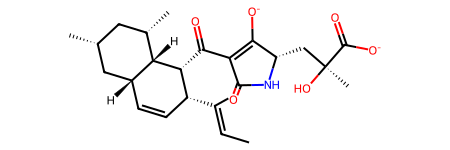

|Atoms|:  32
|Edges|:  34
Data(x=[32, 4], edge_index=[2, 68], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----MODIFIED----
-----


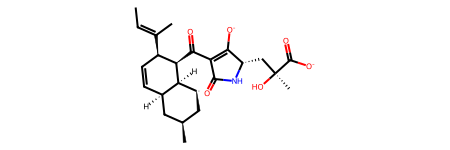

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 3, 0, 1): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[CH][C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


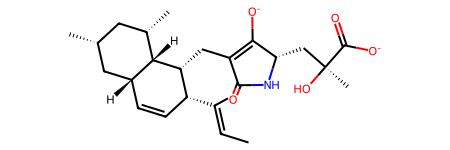

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 3, 0, 0): 1, ('O', 1, 0, 0): 1})
Extra in Modified Counter({('C', 2, 0, 2): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1CC1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


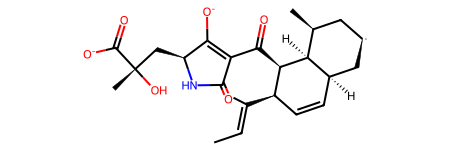

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 3, 0, 1): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[CH]C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


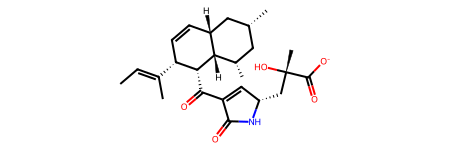

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 3, 0, 0): 1, ('O', 1, -1, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


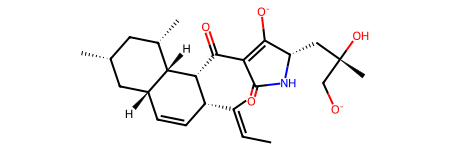

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 3, 0, 0): 1, ('O', 1, 0, 0): 1})
Extra in Modified Counter({('C', 2, 0, 2): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C[O-])NC1=O')
-----


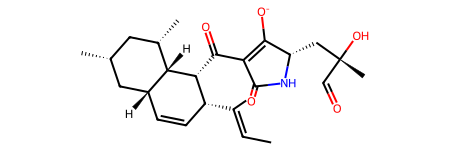

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 3, 0, 0): 1, ('O', 1, -1, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C=O)NC1=O')
-----


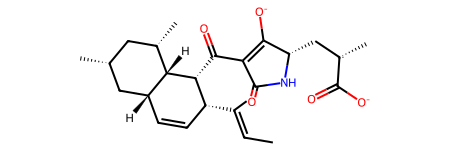

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 4, 0, 0): 1, ('O', 1, 0, 1): 1})
Extra in Modified Counter({('C', 3, 0, 0): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C](C)C(=O)[O-])NC1=O')
-----


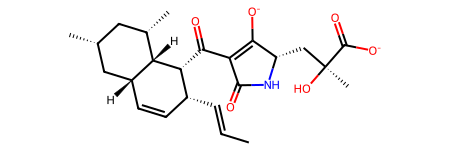

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 3, 0, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='CC=C[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


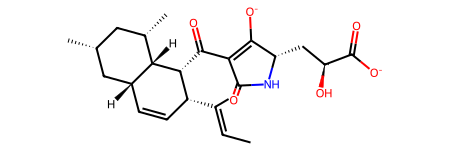

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 4, 0, 0): 1})
Extra in Modified Counter({('C', 3, 0, 0): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C](O)C(=O)[O-])NC1=O')
-----


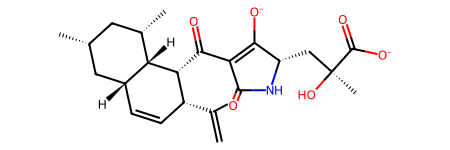

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 2, 0, 1): 1})
Extra in Modified Counter({('C', 1, 0, 2): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='C=C(C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


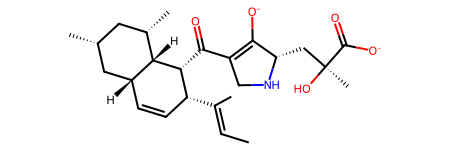

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 3, 0, 0): 1, ('O', 1, 0, 0): 1})
Extra in Modified Counter({('C', 2, 0, 2): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1')


In [36]:
one_node_less = subgraphs_remove_one_leaf(mol=mol)
display(one_node_less)
num_atoms = mol.GetNumAtoms()
print("-----ORIGINAL----")
display(mol)
print("|Atoms|: ", num_atoms)
bonds = mol.GetNumBonds()
print("|Edges|: ", bonds)
print(mol_to_data(mol, atom2idx_debug))

print("-----MODIFIED----")
for m in one_node_less:
    print("-----")
    display(m)
    print("Diff |Atoms|: ", num_atoms - m.GetNumAtoms())
    print("Diff |Edges|: ", bonds - m.GetNumBonds())
    modified_atom_counter = Counter(list(map(lambda atom: tuple(atom_key(atom).values()), m.GetAtoms())))
    print("Extra in Original", atom_counter - modified_atom_counter)
    print("Extra in Modified", modified_atom_counter - atom_counter)
    print(mol_to_data(m, atom2idx_debug))


### Recursive Positive

In [13]:
def subgraphs_remove_one_leaf_iter(
    mol: Mol,
    n: int = None,
) -> list[Mol]:
    """
    Breadth-first enumeration: delete one terminal atom at a time,
    stop when we have `n` unique sub-graphs (or exhaust the lattice).
    Returns a list of RDKit Mol objects.
    """
    if mol.GetNumAtoms() <= 2:
        return []

    queue = [mol]                      # molecules left to expand
    seen = {Chem.MolToSmiles(mol, canonical=True)}
    out: set[Mol] = set()

    while queue and (n is None or len(out) < n):
        parent = queue.pop(0)          # FIFO → breadth-first
        leaves = [a.GetIdx() for a in parent.GetAtoms() if a.GetDegree() == 1]
        print(f"{len(leaves)=}")
        random.shuffle(leaves)

        for idx in leaves:
            rw = Chem.RWMol(parent)
            rw.RemoveAtom(idx)
            try:
                child = rw.GetMol()
                Chem.SanitizeMol(child)
            except Chem.rdchem.KekulizeException:
                continue

            smi = Chem.MolToSmiles(child, canonical=True)
            if smi in seen:
                continue

            seen.add(smi)
            out.add(child)
            queue.append(child)        # expand this one later

            if n is not None and len(out) >= n:
                break

    return out

len(leaves)=11
len(leaves)=10
len(leaves)=10
len(leaves)=10
len(leaves)=10
len(leaves)=10


{<rdkit.Chem.rdchem.Mol at 0x10308ef80>,
 <rdkit.Chem.rdchem.Mol at 0x17f785310>}

|Atoms|:  32
|Edges|:  34
-----


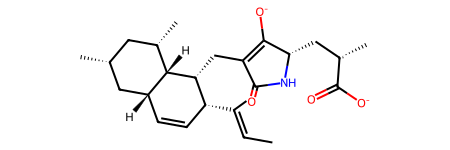

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('O', 1, 0, 0): 1, ('C', 4, 0, 0): 1, ('O', 1, 0, 1): 1})
Extra in Modified Counter({('C', 2, 0, 2): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1CC1=C([O-])[C@H](C[C](C)C(=O)[O-])NC1=O')
-----


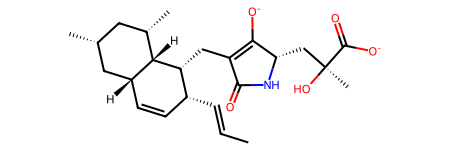

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 3, 0, 0): 2, ('C', 1, 0, 3): 1, ('O', 1, 0, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1, ('C', 2, 0, 2): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='CC=C[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1CC1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


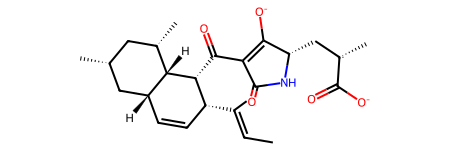

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 4, 0, 0): 1, ('O', 1, 0, 1): 1})
Extra in Modified Counter({('C', 3, 0, 0): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C](C)C(=O)[O-])NC1=O')
-----


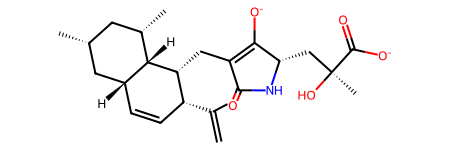

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 2, 0, 1): 1, ('C', 3, 0, 0): 1, ('O', 1, 0, 0): 1})
Extra in Modified Counter({('C', 1, 0, 2): 1, ('C', 2, 0, 2): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C=C(C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1CC1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


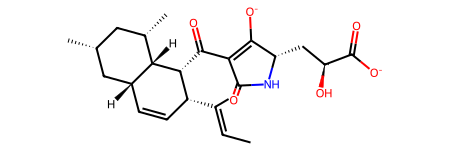

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 4, 0, 0): 1})
Extra in Modified Counter({('C', 3, 0, 0): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C](O)C(=O)[O-])NC1=O')
-----


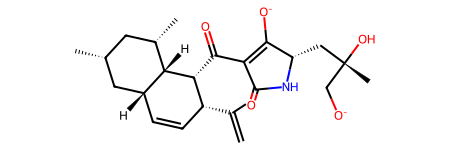

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 2, 0, 1): 1, ('C', 3, 0, 0): 1, ('O', 1, 0, 0): 1})
Extra in Modified Counter({('C', 1, 0, 2): 1, ('C', 2, 0, 2): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C=C(C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C[O-])NC1=O')
-----


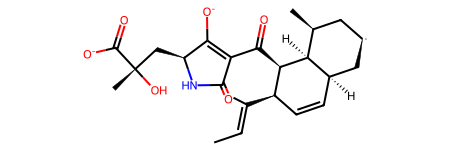

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 3, 0, 1): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[CH]C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


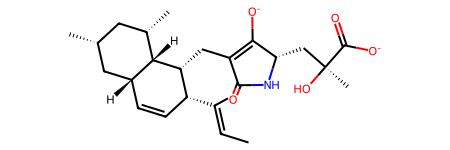

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 3, 0, 0): 1, ('O', 1, 0, 0): 1})
Extra in Modified Counter({('C', 2, 0, 2): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1CC1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


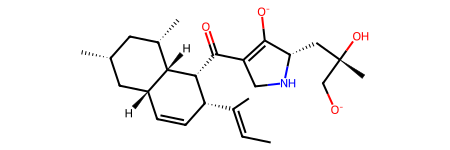

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 3, 0, 0): 2, ('O', 1, 0, 0): 2})
Extra in Modified Counter({('C', 2, 0, 2): 2})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C[O-])NC1')
-----


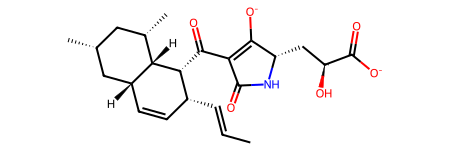

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 1, 0, 3): 2, ('C', 4, 0, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='CC=C[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C](O)C(=O)[O-])NC1=O')
-----


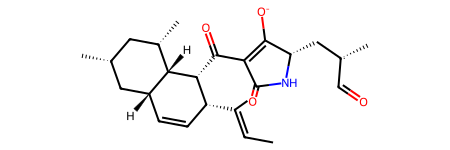

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('O', 1, -1, 0): 1, ('C', 4, 0, 0): 1, ('O', 1, 0, 1): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C](C)C=O)NC1=O')
-----


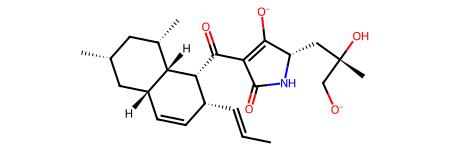

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 3, 0, 0): 2, ('C', 1, 0, 3): 1, ('O', 1, 0, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1, ('C', 2, 0, 2): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='CC=C[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C[O-])NC1=O')
-----


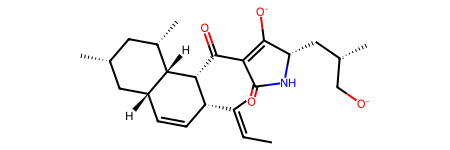

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('O', 1, 0, 0): 1, ('C', 4, 0, 0): 1, ('O', 1, 0, 1): 1})
Extra in Modified Counter({('C', 2, 0, 2): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C](C)C[O-])NC1=O')
-----


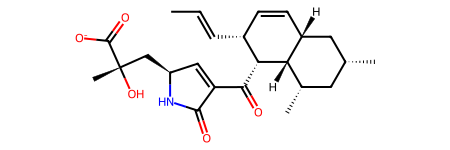

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 3, 0, 0): 2, ('C', 1, 0, 3): 1, ('O', 1, -1, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 2})
Data(x=[30, 4], edge_index=[2, 64], smiles='CC=C[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


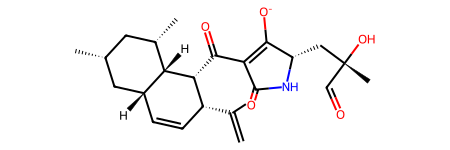

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 3, 0, 0): 1, ('O', 1, -1, 0): 1})
Extra in Modified Counter({('C', 1, 0, 2): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C=C(C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C=O)NC1=O')
-----


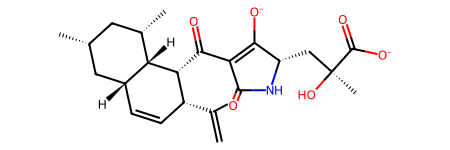

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 2, 0, 1): 1})
Extra in Modified Counter({('C', 1, 0, 2): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='C=C(C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


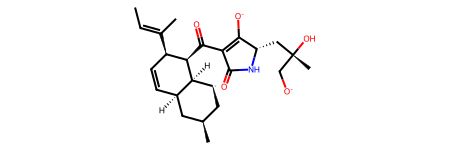

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 3, 0, 0): 1, ('C', 3, 0, 1): 1, ('O', 1, 0, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1, ('C', 2, 0, 2): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[CH][C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C[O-])NC1=O')
-----


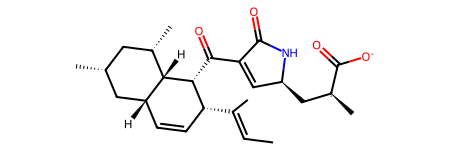

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('O', 1, -1, 0): 1, ('C', 4, 0, 0): 1, ('O', 1, 0, 1): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C[C@H](C[C](C)C(=O)[O-])NC1=O')
-----


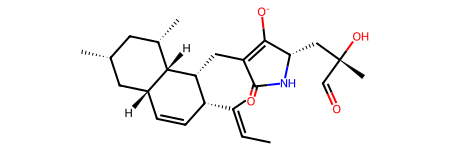

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 3, 0, 0): 2, ('O', 1, 0, 0): 1, ('O', 1, -1, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1, ('C', 2, 0, 2): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1CC1=C([O-])[C@H](C[C@](C)(O)C=O)NC1=O')
-----


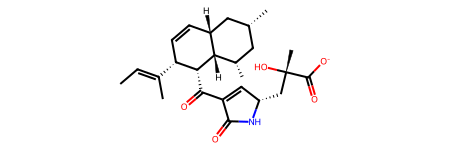

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 3, 0, 0): 1, ('O', 1, -1, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


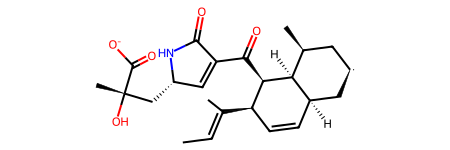

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 3, 0, 0): 1, ('C', 3, 0, 1): 1, ('O', 1, -1, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 2})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[CH]C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


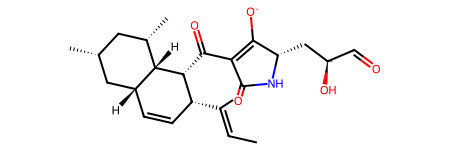

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 1, 0, 3): 1, ('O', 1, -1, 0): 1, ('C', 4, 0, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C](O)C=O)NC1=O')
-----


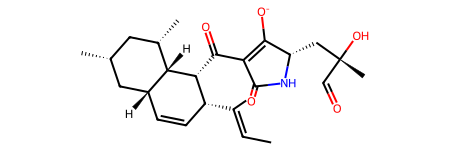

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 3, 0, 0): 1, ('O', 1, -1, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C=O)NC1=O')
-----


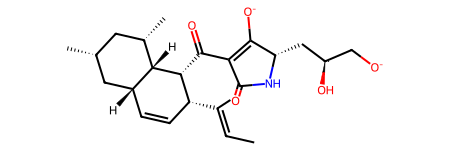

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 1, 0, 3): 1, ('O', 1, 0, 0): 1, ('C', 4, 0, 0): 1})
Extra in Modified Counter({('C', 2, 0, 2): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C](O)C[O-])NC1=O')
-----


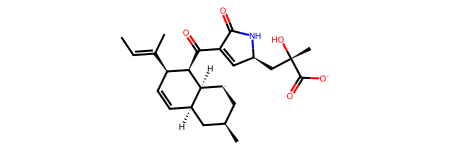

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 3, 0, 0): 1, ('C', 3, 0, 1): 1, ('O', 1, -1, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 2})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[CH][C@@H]2[C@@H]1C(=O)C1=C[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


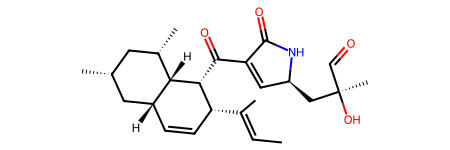

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 3, 0, 0): 2, ('O', 1, -1, 0): 2})
Extra in Modified Counter({('C', 2, 0, 1): 2})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C[C@H](C[C@](C)(O)C=O)NC1=O')
-----


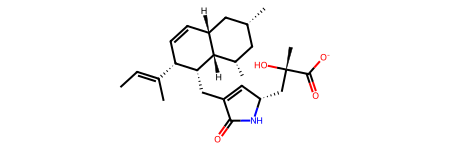

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 3, 0, 0): 2, ('O', 1, 0, 0): 1, ('O', 1, -1, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1, ('C', 2, 0, 2): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1CC1=C[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


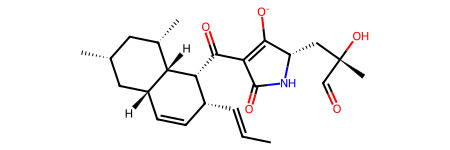

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 3, 0, 0): 2, ('C', 1, 0, 3): 1, ('O', 1, -1, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 2})
Data(x=[30, 4], edge_index=[2, 64], smiles='CC=C[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C=O)NC1=O')
-----


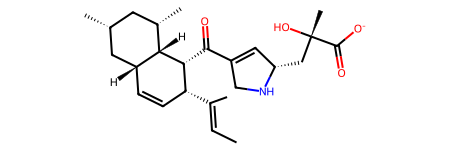

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 3, 0, 0): 2, ('O', 1, 0, 0): 1, ('O', 1, -1, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1, ('C', 2, 0, 2): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C[C@H](C[C@](C)(O)C(=O)[O-])NC1')
-----


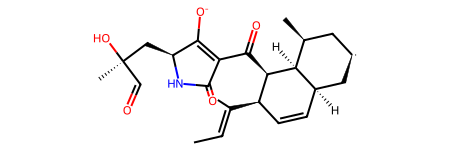

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 3, 0, 0): 1, ('C', 3, 0, 1): 1, ('O', 1, -1, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 2})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[CH]C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C=O)NC1=O')
-----


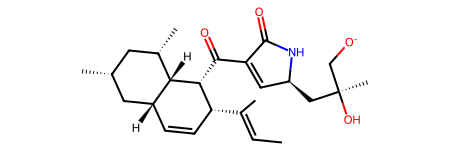

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 3, 0, 0): 2, ('O', 1, 0, 0): 1, ('O', 1, -1, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1, ('C', 2, 0, 2): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C[C@H](C[C@](C)(O)C[O-])NC1=O')
-----


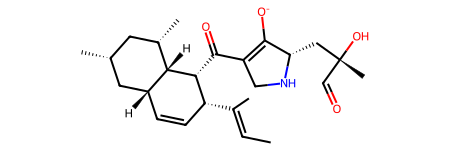

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 3, 0, 0): 2, ('O', 1, 0, 0): 1, ('O', 1, -1, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1, ('C', 2, 0, 2): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C=O)NC1')
-----


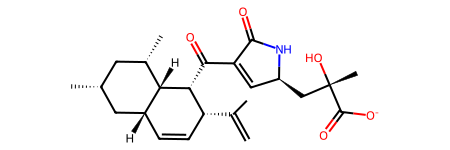

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 3, 0, 0): 1, ('O', 1, -1, 0): 1})
Extra in Modified Counter({('C', 1, 0, 2): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C=C(C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


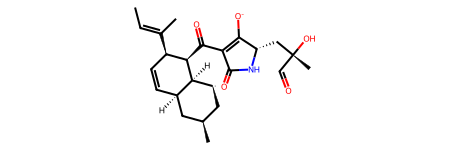

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 3, 0, 0): 1, ('C', 3, 0, 1): 1, ('O', 1, -1, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 2})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[CH][C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C=O)NC1=O')
-----


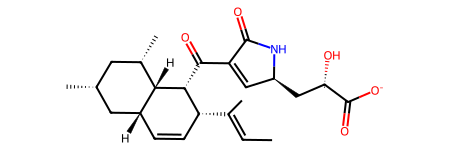

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 1, 0, 3): 1, ('O', 1, -1, 0): 1, ('C', 4, 0, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C[C@H](C[C](O)C(=O)[O-])NC1=O')
-----


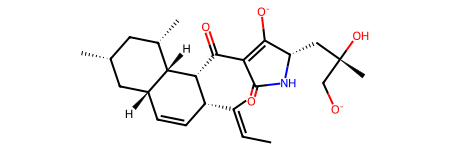

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 3, 0, 0): 1, ('O', 1, 0, 0): 1})
Extra in Modified Counter({('C', 2, 0, 2): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C[O-])NC1=O')
-----


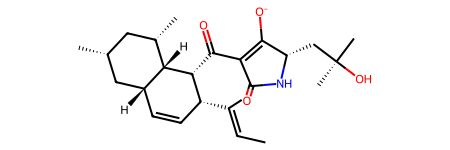

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 3, 0, 0): 1, ('O', 1, 0, 0): 1, ('O', 1, -1, 0): 1})
Extra in Modified Counter({('C', 1, 0, 3): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](CC(C)(C)O)NC1=O')
-----


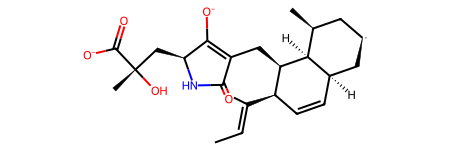

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 3, 0, 0): 1, ('C', 3, 0, 1): 1, ('O', 1, 0, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1, ('C', 2, 0, 2): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[CH]C[C@H](C)[C@@H]2[C@@H]1CC1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


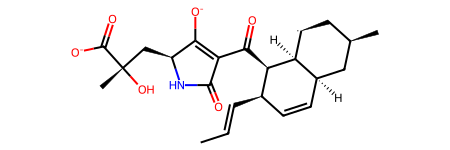

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 1, 0, 3): 2, ('C', 3, 0, 0): 1, ('C', 3, 0, 1): 1})
Extra in Modified Counter({('C', 2, 0, 1): 2})
Data(x=[30, 4], edge_index=[2, 64], smiles='CC=C[C@@H]1C=C[C@@H]2C[C@H](C)C[CH][C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


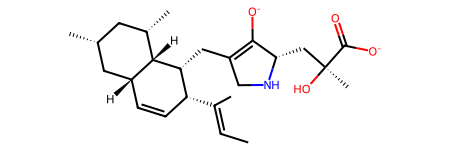

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 3, 0, 0): 2, ('O', 1, 0, 0): 2})
Extra in Modified Counter({('C', 2, 0, 2): 2})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1CC1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1')
-----


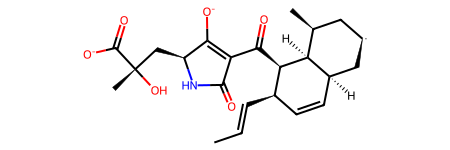

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 1, 0, 3): 2, ('C', 3, 0, 0): 1, ('C', 3, 0, 1): 1})
Extra in Modified Counter({('C', 2, 0, 1): 2})
Data(x=[30, 4], edge_index=[2, 64], smiles='CC=C[C@@H]1C=C[C@@H]2C[CH]C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


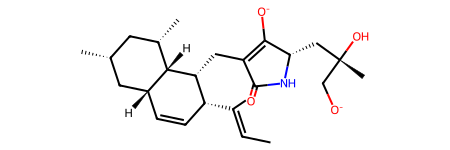

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 3, 0, 0): 2, ('O', 1, 0, 0): 2})
Extra in Modified Counter({('C', 2, 0, 2): 2})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1CC1=C([O-])[C@H](C[C@](C)(O)C[O-])NC1=O')
-----


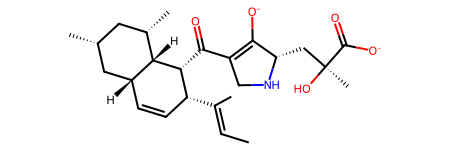

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 3, 0, 0): 1, ('O', 1, 0, 0): 1})
Extra in Modified Counter({('C', 2, 0, 2): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1')
-----


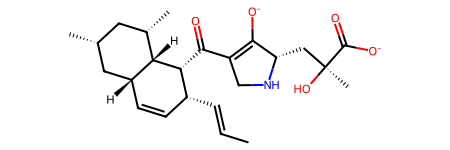

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 3, 0, 0): 2, ('C', 1, 0, 3): 1, ('O', 1, 0, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1, ('C', 2, 0, 2): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='CC=C[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1')
-----


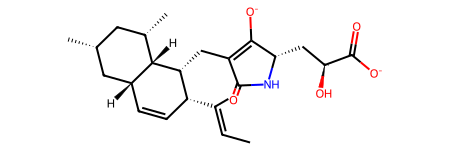

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 1, 0, 3): 1, ('O', 1, 0, 0): 1, ('C', 4, 0, 0): 1})
Extra in Modified Counter({('C', 2, 0, 2): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1CC1=C([O-])[C@H](C[C](O)C(=O)[O-])NC1=O')
-----


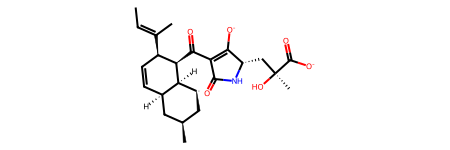

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 3, 0, 1): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[CH][C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


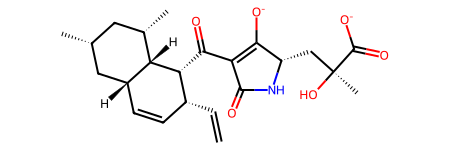

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 1, 0, 3): 2, ('C', 3, 0, 0): 1})
Extra in Modified Counter({('C', 1, 0, 2): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C=C[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


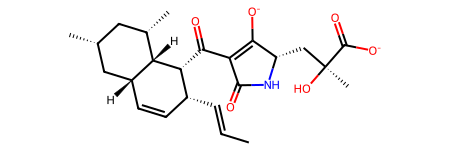

Diff |Atoms|:  1
Diff |Edges|:  1
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 3, 0, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1})
Data(x=[31, 4], edge_index=[2, 66], smiles='CC=C[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


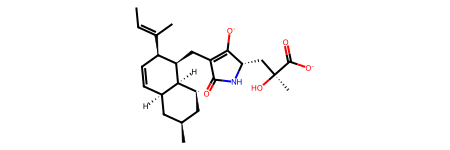

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 3, 0, 0): 1, ('C', 3, 0, 1): 1, ('O', 1, 0, 0): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1, ('C', 2, 0, 2): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='C/C=C(\C)[C@@H]1C=C[C@@H]2C[C@H](C)C[CH][C@@H]2[C@@H]1CC1=C([O-])[C@H](C[C@](C)(O)C(=O)[O-])NC1=O')
-----


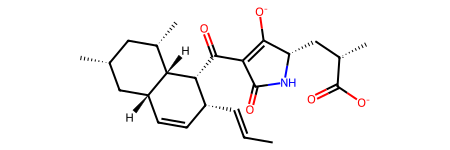

Diff |Atoms|:  2
Diff |Edges|:  2
Extra in Original Counter({('C', 1, 0, 3): 1, ('C', 4, 0, 0): 1, ('O', 1, 0, 1): 1})
Extra in Modified Counter({('C', 2, 0, 1): 1})
Data(x=[30, 4], edge_index=[2, 64], smiles='CC=C[C@@H]1C=C[C@@H]2C[C@H](C)C[C@H](C)[C@@H]2[C@@H]1C(=O)C1=C([O-])[C@H](C[C](C)C(=O)[O-])NC1=O')


In [14]:
recursively_reduced = subgraphs_remove_one_leaf_iter(mol=mol, n=50)
display(recursively_reduced)
num_atoms = mol.GetNumAtoms()
print("|Atoms|: ", num_atoms)
bonds = mol.GetNumBonds()
print("|Edges|: ", bonds)


for m in recursively_reduced:
    print("-----")
    display(m)
    print("Diff |Atoms|: ", num_atoms - m.GetNumAtoms())
    print("Diff |Edges|: ", bonds - m.GetNumBonds())
    modified_atom_counter = Counter(list(map(lambda atom: tuple(atom_key(atom).values()), m.GetAtoms())))
    print("Extra in Original", atom_counter - modified_atom_counter)
    print("Extra in Modified", modified_atom_counter - atom_counter)
    print(mol_to_data(m, atom2idx_debug))


#### Negative

In [ ]:
def graphs_add_one_bond(mol: Mol, n: int, atom2idx: dict, max_tries=15):
    out, seen = set(), set()
    atoms = list(range(mol.GetNumAtoms()))
    orig_edges = {tuple(sorted((b.GetBeginAtomIdx(), b.GetEndAtomIdx())))
                  for b in mol.GetBonds()}
    tries = 0
    while len(out) < n and tries < max_tries * n:
        tries += 1
        i, j = random.sample(atoms, 2)
        if tuple(sorted((i, j))) in orig_edges:
            continue
        rw = Chem.RWMol(mol)
        rw.AddBond(i, j, Chem.BondType.SINGLE)
        try:
            aug = rw.GetMol()
            Chem.SanitizeMol(aug)
        except Chem.rdchem.KekulizeException:
            continue
        smi = Chem.MolToSmiles(aug, canonical=True)
        if smi in seen:
            continue
        out.add(mol_to_data(aug, atom2idx))
        seen.add(smi)
    return out

SYMBOL_POOL = ['B', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I']

def graphs_mutate_one_atom(mol: Mol, n: int, atom2idx: dict, max_tries=20):
    res, seen = set(), set()
    pt = Chem.GetPeriodicTable()
    tries = 0
    while len(res) < n and tries < max_tries * n:
        tries += 1
        idx = random.randrange(mol.GetNumAtoms())
        atom = mol.GetAtomWithIdx(idx)
        new_symbol = random.choice([s for s in SYMBOL_POOL if s != atom.GetSymbol()])
        rw = Chem.RWMol(mol)
        a_rw = rw.GetAtomWithIdx(idx)
        a_rw.SetAtomicNum(pt.GetAtomicNumber(new_symbol))
        try:
            mut = rw.GetMol()
            Chem.SanitizeMol(mut)
        except Chem.rdchem.KekulizeException:
            continue
        smi = Chem.MolToSmiles(mut, canonical=True)
        if smi in seen:
            continue
        # skip cases introducing atom types outside the original lookup
        if any((atom_key(a) not in atom2idx) for a in mut.GetAtoms()):
            continue
        res.add(mol_to_data(mut, atom2idx))
        seen.add(smi)
    return res

## Positive Extract Aromatic Subgraphs

In [ ]:
from collections import Counter
from rdkit.Chem import Mol, ValenceType
mol.UpdatePropertyCache(strict=False)
display(mol)
# Ring information
info = mol.GetRingInfo()

print(dir(info))
print(info.NumRings())
rings = info.AtomRings()
print(rings)

ring_atoms = [
    [mol.GetAtomWithIdx(i) for i in ring]
    for ring in rings
]
print(ring_atoms)

for ring in ring_atoms:
    print("---RING---")
    for atom in ring:
        print({
            "symbol": atom.GetSymbol(),
            "degree": atom.GetDegree(),
            "valence": atom.GetValence(ValenceType.EXPLICIT),
            "charge": atom.GetFormalCharge(),
            "hydorogens": atom.GetTotalNumHs(),
            "isAromatic": atom.GetIsAromatic(),
            "isPartOfRing": atom.IsInRing(),
            "isInRingSize5": atom.IsInRingSize(5),
            "isInRingSize6": atom.IsInRingSize(6),
        })

ring_symbol_ctrs = [
    Counter([mol.GetAtomWithIdx(i).GetSymbol() for i in ring])
    for ring in rings
]
print(ring_symbol_ctrs)



# Atomatic rings
aromatic_rings = [
    ring for ring in info.AtomRings()
    if all(mol.GetAtomWithIdx(i) for i in ring)
]


In [ ]:
import random
from rdkit import Chem
from rdkit.Chem import rdchem


def _smiles_fragment(mol: rdchem.Mol, atom_ids) -> str:
    """Canonical SMILES for a chosen atom subset (hash-friendly key)."""
    return Chem.MolFragmentToSmiles(
        mol,
        atomsToUse=list(atom_ids),
        canonical=True,
        isomericSmiles=True,
    )


def ring_core_subgraphs(mol: rdchem.Mol, n: int | None = None) -> list:
    """
    Return up to `n` unique single-ring fragments (no substituents).
    """
    rings = list(mol.GetRingInfo().AtomRings())  # <-- convert to list
    random.shuffle(rings)

    out, seen = [], set()
    for ring in rings:
        smi = _smiles_fragment(mol, ring)
        if smi in seen:
            continue
        seen.add(smi)
        sub = Chem.MolFromSmiles(smi)
        if sub is not None:
            out.append(sub)
            if n is not None and len(out) >= n:
                break
    return out


def ring_plus_one_substituent(mol: rdchem.Mol, n: int | None = None) -> list:
    """
    Return up to `n` unique fragments consisting of a ring plus
    exactly ONE directly attached non-ring atom.
    """
    rings = list(mol.GetRingInfo().AtomRings())  # <-- convert to list
    random.shuffle(rings)

    out, seen = [], set()
    for ring in rings:
        ring_set = set(ring)
        for ra in ring:
            for nb in mol.GetAtomWithIdx(ra).GetNeighbors():
                j = nb.GetIdx()
                if j in ring_set:
                    continue
                atoms = ring_set | {j}
                smi = _smiles_fragment(mol, atoms)
                if smi in seen:
                    continue
                seen.add(smi)
                sub = Chem.MolFromSmiles(smi)
                if sub is not None:
                    out.append(sub)
                    if n is not None and len(out) >= n:
                        return out
    return out

In [ ]:
rings = ring_core_subgraphs(mol)
print(len(rings))
for r in rings:
    display(r)